## Optimising latent space dynamics for computational efficiency

Chemical kinetics

\begin{equation}
\frac{\text{d}z_{i}}{\text{d}t} \ = \ A_{ij} z_{j}+B_{ijk}z_jz_k
\end{equation}

In [1]:
import torch
import torchode          as to
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl

from tqdm   import tqdm
from time   import time

from matplotlib          import rcParams
rcParams.update({'figure.dpi': 200})
mpl.rcParams.update({'font.size': 10})
plt.rcParams['figure.dpi'] = 200



In [38]:
def g(t, z, args):
    '''
    ODE function of the latent dynamics. 
    '''
    A, B = args
    return torch.einsum("ij, bj -> bi", A, z) + torch.einsum("ijk, bj, bk -> bi", B, z, z)


def make_args(n_latent):
    '''
    Initialise tensors A and B for the ODE function.
    '''
    A  = torch.randn(n_latent, n_latent)
    B  = torch.randn(n_latent, n_latent, n_latent)

    return A,B

def make_setup(n_batch, n_latent, dt):
    '''
    Create the correct input torch tensors, given
        - the batch size, n_batch
        - the size of the latent space, n_latent.
    
    Creates randomised latent vector with values between -1 and 1.
    '''

    ## Randomised latent vector
    z0 = torch.rand(n_latent)*2-1

    ## Initial conditions
    t0 = 0.0

    ## End time and time step
    t1 = 1.e0
    # dt = 1.0e-2
    t_eval = torch.arange(t0, t1, step=dt)

    ## Create batches
    t_eval_batch    = torch.empty(n_batch, t_eval.shape[0])
    z0_batch        = torch.empty(n_batch,     z0.shape[0])

    t_eval_batch[:] = t_eval
    z0_batch        = torch.rand(n_batch,n_latent) *2-1

    return t_eval_batch, z0_batch, dt


def solver(args, atol, rtol, n_batch, n_latent,dt, DEVICE):
    t_eval,z_0,dt = make_setup(n_batch, n_latent,dt)

    odeterm = to.ODETerm(g, with_args=True)
    step_method          = to.Dopri5(term=odeterm)
    step_size_controller = to.IntegralController(atol=atol, rtol=rtol, term=odeterm)
    adjoint              = to.AutoDiffAdjoint(step_method, step_size_controller).to(DEVICE) # type: ignore

    jit_solver = torch.compile(adjoint)

    problem = to.InitialValueProblem(
        y0     = z_0,  ## "view" is om met de batches om te gaan
        t_eval = t_eval,
    )

    solution = jit_solver.solve(problem, args=args)

    return t_eval,solution.ys.data, dt


def remove_num_noise(sol, lim):
    w = np.where(np.logical_or(np.abs(sol) > lim,np.isnan(sol)))
    idx = [0]
    for i in range(1,len(w[0])):
        if w[0][i] != w[0][i-1]:
            idx.append(i)

    return w,np.array(idx)

def get_dynamics(sol, lim= 10, plot = False):

    if plot:
        fig, axs = plt.subplots(2,1,figsize=(8,6))
        ax1 = axs[0]
        ax2 = axs[1]

        a = 0.1

    w,idx = remove_num_noise(sol, lim)
    # print('+++++++++++++++++')
    # print(w, idx)
    # print('+++++++++++++++++')

    dyn = list()

    step = 1
    for n in tqdm(range(0,len(idx), step)):
        i = w[0][idx[n]]
        j = w[1][idx[n]]
        
        z = sol[i][:j]
        z0 = sol[i][0]
        Δz = z - z0
        dyn.append(Δz)

        if plot:
            ax1.plot(Δz, '-', alpha = a, label = i)
            ax2.plot(z, '-', alpha = a, label = i)

    if plot:
        ax1.set_ylabel('$z-z_0$')
        ax2.set_ylabel('$z$')

        ylim = 10.1
        xlim = 1000
        for ax in axs:
            ax.set_ylim([-ylim,ylim]) # type: ignore
            ax.set_xlim([0,xlim])
            ax.set_xlabel('step')
            ax.grid(True, linestyle = '--', linewidth = 0.2)
        ax1.set(xticklabels=[])

        fig.tight_layout()
        fig.subplots_adjust(hspace = 0.07)

        print('     >> Plotting...')
        plt.show()

    return idx, dyn

def get_sigma(idx, dyn, dt,plot = False):
    
    if plot:
        a = 0.5
        fig, ax1 = plt.subplots(figsize=(8,6))

    sigmas = np.zeros([int(dt**(-1)),len(idx)])
    for i in tqdm(range(len(dyn))):   
        sigma = torch.std(dyn[i], axis = 1)
        for j in range(len(sigma)-1):
            # print(j)
            sigmas[j][i] = sigma[j]

        if plot:
            ax1.plot(sigma, '-x', lw = 0.5, markersize = 1, alpha = a)


    stds = list()
    for i in range(len(sigmas)):
        mu = np.mean(sigmas[i][sigmas[i] != 0])
        stds.append(mu)

    if plot:
        ax1.plot(stds, '-x', lw = 1, markersize = 1.5, color = 'k', label = 'mean $\\sigma$')

        ax1.set_ylabel('$\\sigma$')
        ax1.set_xlabel('step')
        plt.legend(fontsize = 8)

        print('     >> Plotting...')
        plt.show()

    return stds


def dynamics_test(n_latent, n_batch,lim, dt,atol, rtol, DEVICE, plot = False):
    print('\n-------------------------')
    print('Input:')
    print('     - n_latent', n_latent)
    print('     - n_batch ', n_batch)
    print('     - atol    ', atol)
    print('     - rtol    ', rtol)

    args = make_args(n_latent)

    print(' >> Solving the ODE...')
    t,sol,dt = solver(args, atol, rtol, n_batch, n_latent, dt, DEVICE)

    print(' >> Getting the latent dynamics...')
    idx, dyn = get_dynamics(sol, lim, plot)
    print(' >> Calculating standard deviations...')
    stds = get_sigma(idx, dyn, dt,plot)

    return stds

In [48]:
cuda   = False
DEVICE = torch.device("cuda" if cuda else "cpu")

n_latents = [1, 2, 5, 8, 10, 12, 16, 20, 25, 32, 48, 64, 128]
# n_latents = [10]
n_batch  = 100
dt = 1.e-3


atol = 1.0e-5
rtol = 1.0e-2

plot = True

In [49]:
lim = 10

stds = list()
for i in range(len(n_latents)):
    std = dynamics_test(n_latents[i], n_batch,lim, dt, atol, rtol, DEVICE, plot = False)
    stds.append(std)


-------------------------
Input:
     - n_latent 1
     - n_batch  100
     - atol     1e-05
     - rtol     0.01
 >> Solving the ODE...
 >> Getting the latent dynamics...


  0%|          | 0/1 [00:00<?, ?it/s]

IndexError: index 0 is out of bounds for axis 0 with size 0

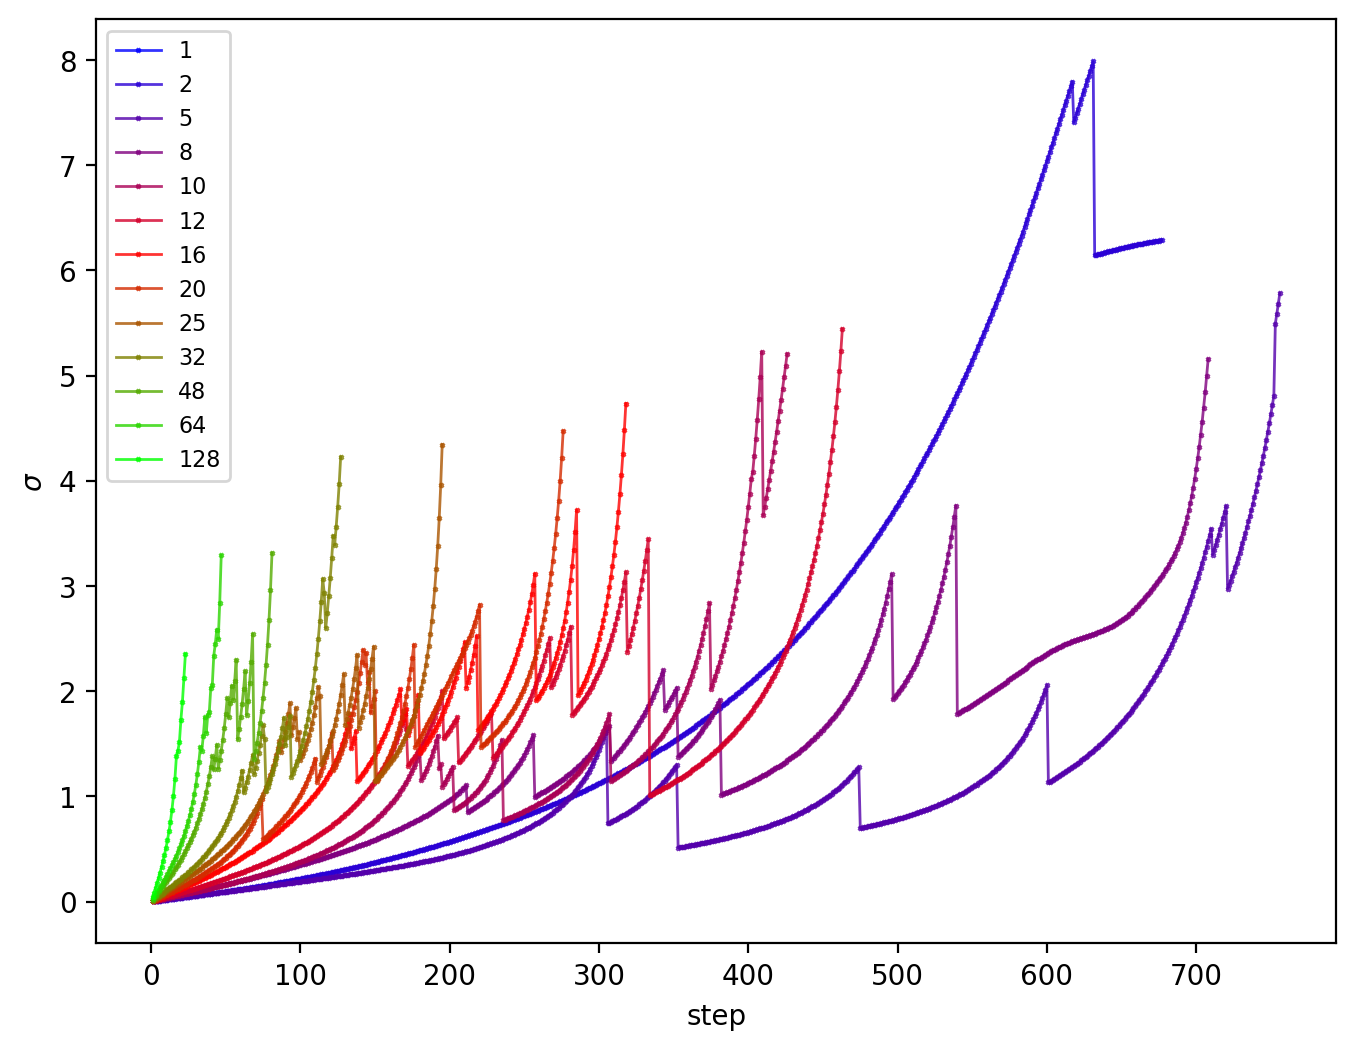

In [34]:
colors = mpl.cm.brg(np.linspace(0, 1, len(n_latents)))

fig, ax1 = plt.subplots(figsize=(8,6))

a = 0.8

for i in range(len(stds)):
    ax1.plot(stds[i], '-x', lw = 1, markersize = 1.5, color = colors[i], label = n_latents[i], alpha = a)


ax1.set_ylabel('$\\sigma$')
ax1.set_xlabel('step')
plt.legend(fontsize = 8)


plt.show()

Input:
     - n_latent 5
     - n_batch  100
     - atol     1e-05
     - rtol     0.01
 >> Solving the ODE...
 >> Getting the latent dynamics...


100%|██████████| 85/85 [00:03<00:00, 23.31it/s]


     >> Plotting...


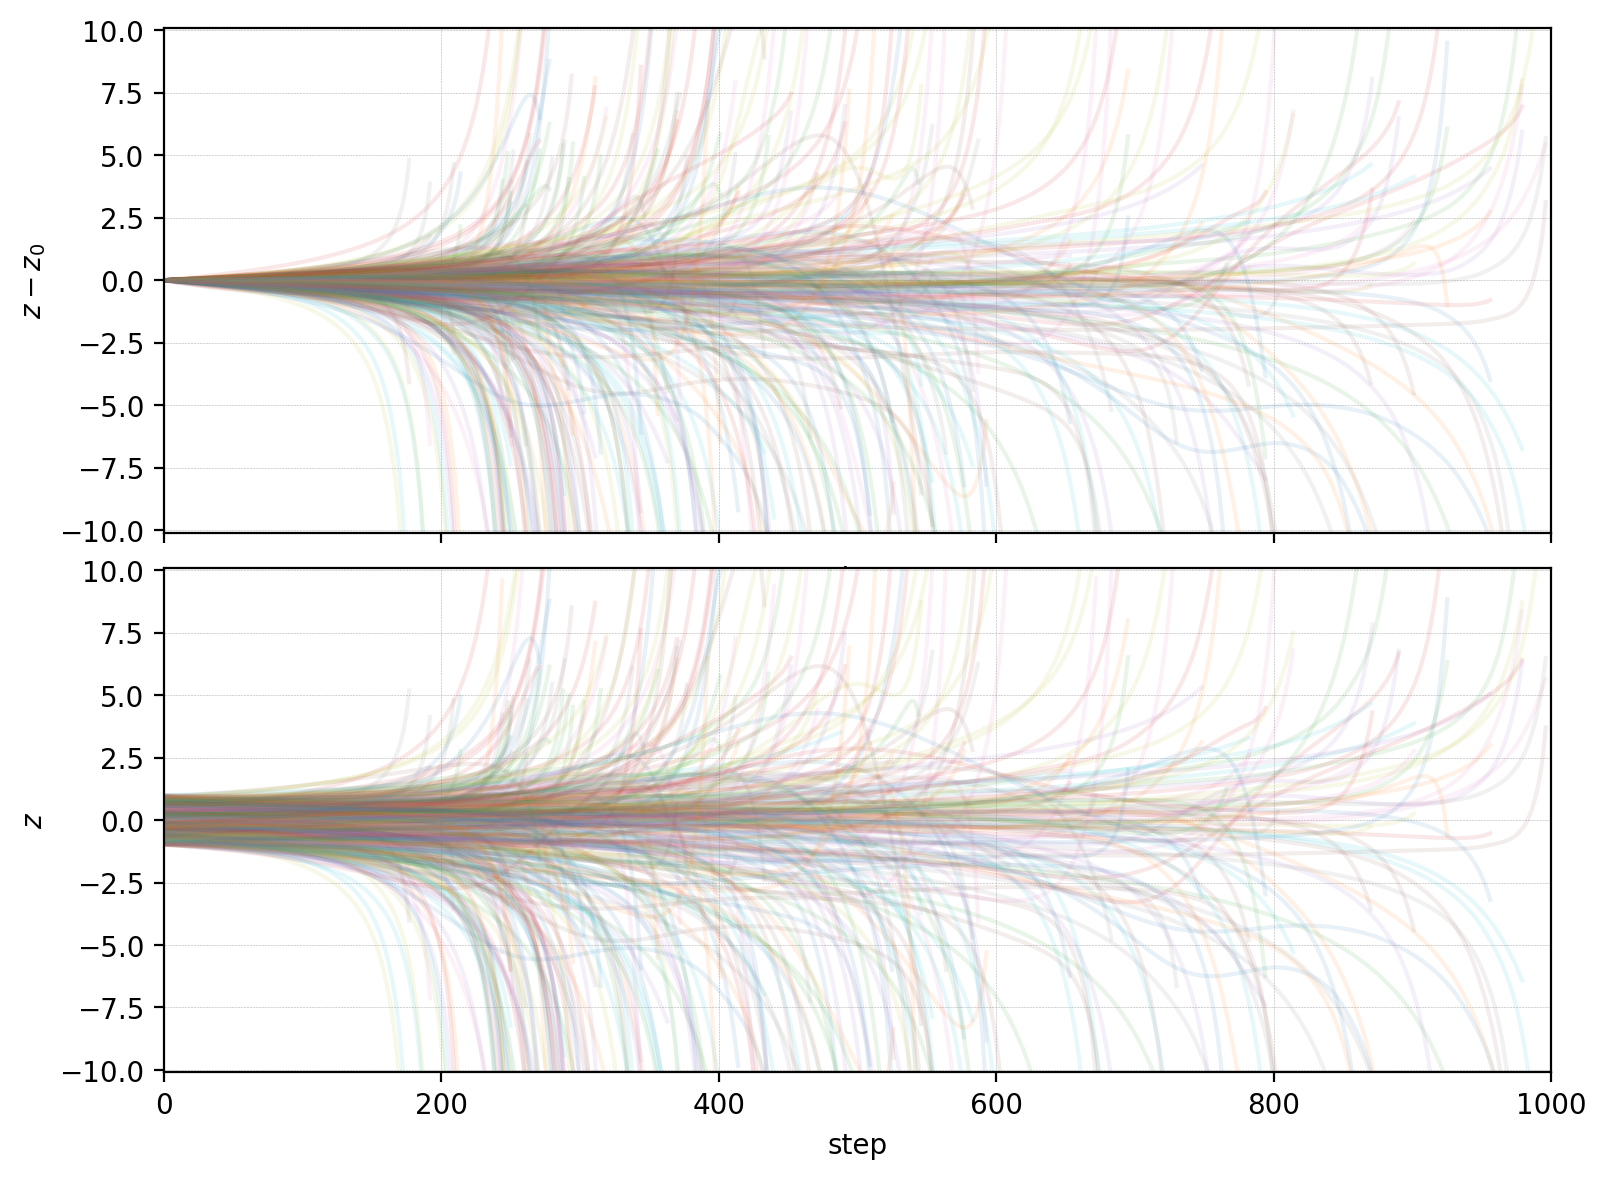

 >> Calculating standard deviations...


100%|██████████| 85/85 [00:00<00:00, 103.70it/s]


     >> Plotting...


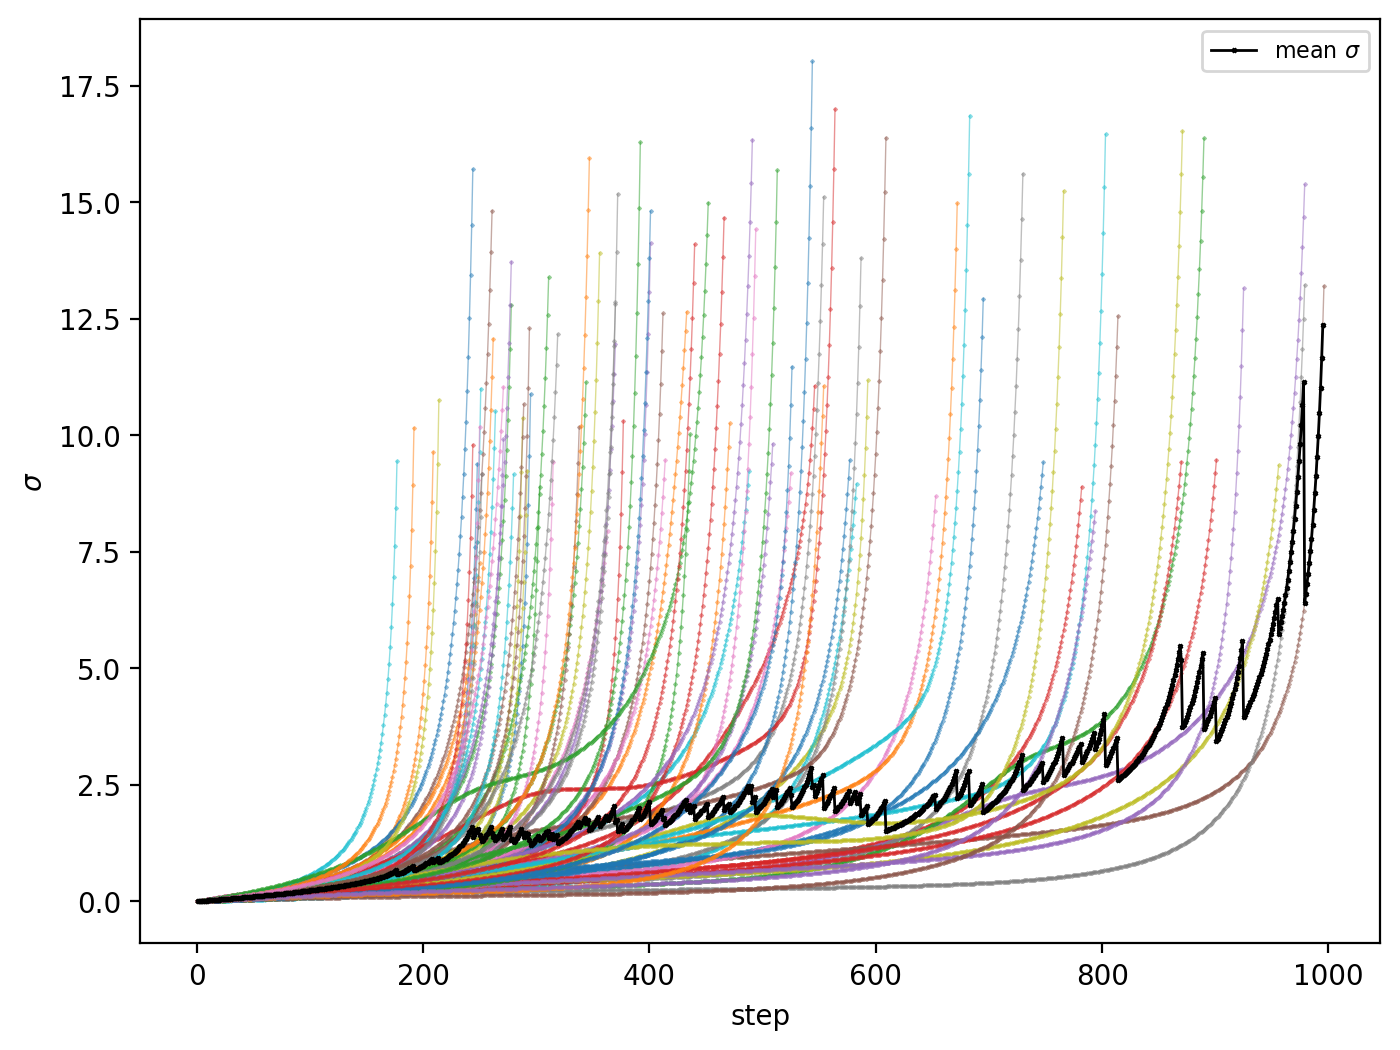

In [175]:
stds_5 = dynamics_test(5, 100, dt, atol, rtol, DEVICE, plot = True)

Input:
     - n_latent 10
     - n_batch  100
     - atol     1e-05
     - rtol     0.01
 >> Solving the ODE...
 >> Getting the latent dynamics...


100%|██████████| 100/100 [00:04<00:00, 21.76it/s]


     >> Plotting...


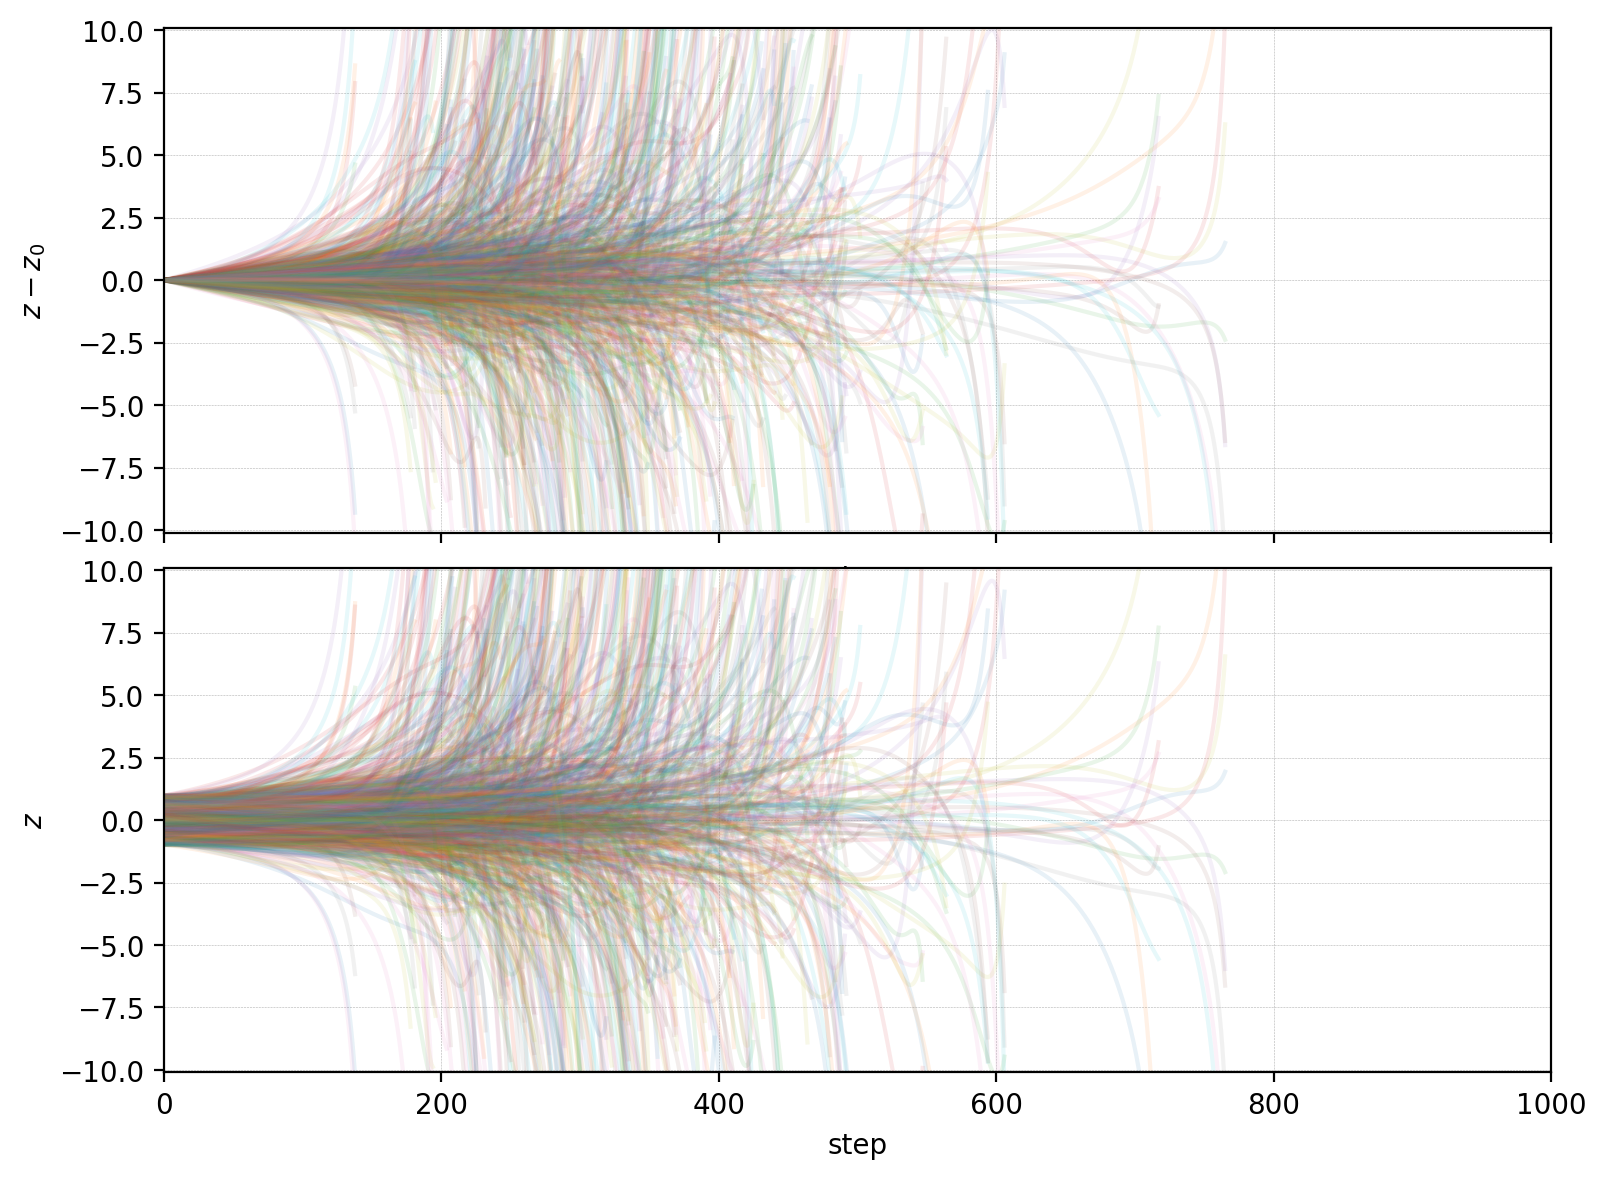

 >> Calculating standard deviations...


100%|██████████| 100/100 [00:00<00:00, 223.69it/s]


     >> Plotting...


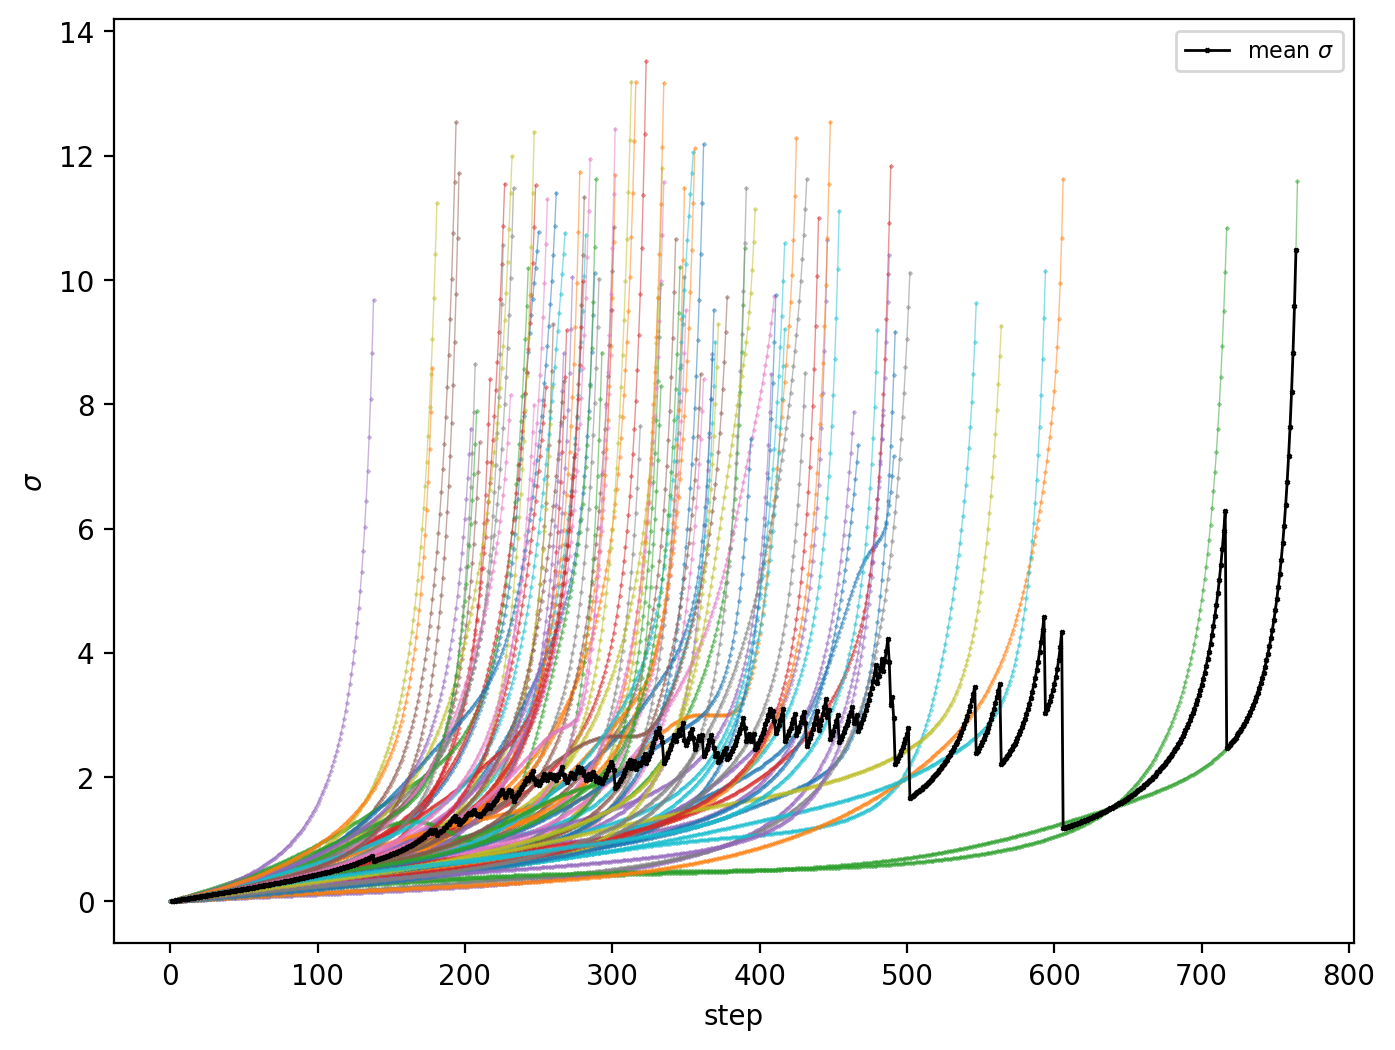

In [174]:
stds_10 = dynamics_test(10, 100, dt, atol, rtol, DEVICE, plot = True)

Input:
     - n_latent 20
     - n_batch  100
     - atol     1e-05
     - rtol     0.01
 >> Solving the ODE...
 >> Getting the latent dynamics...


100%|██████████| 100/100 [00:05<00:00, 17.83it/s]


     >> Plotting...


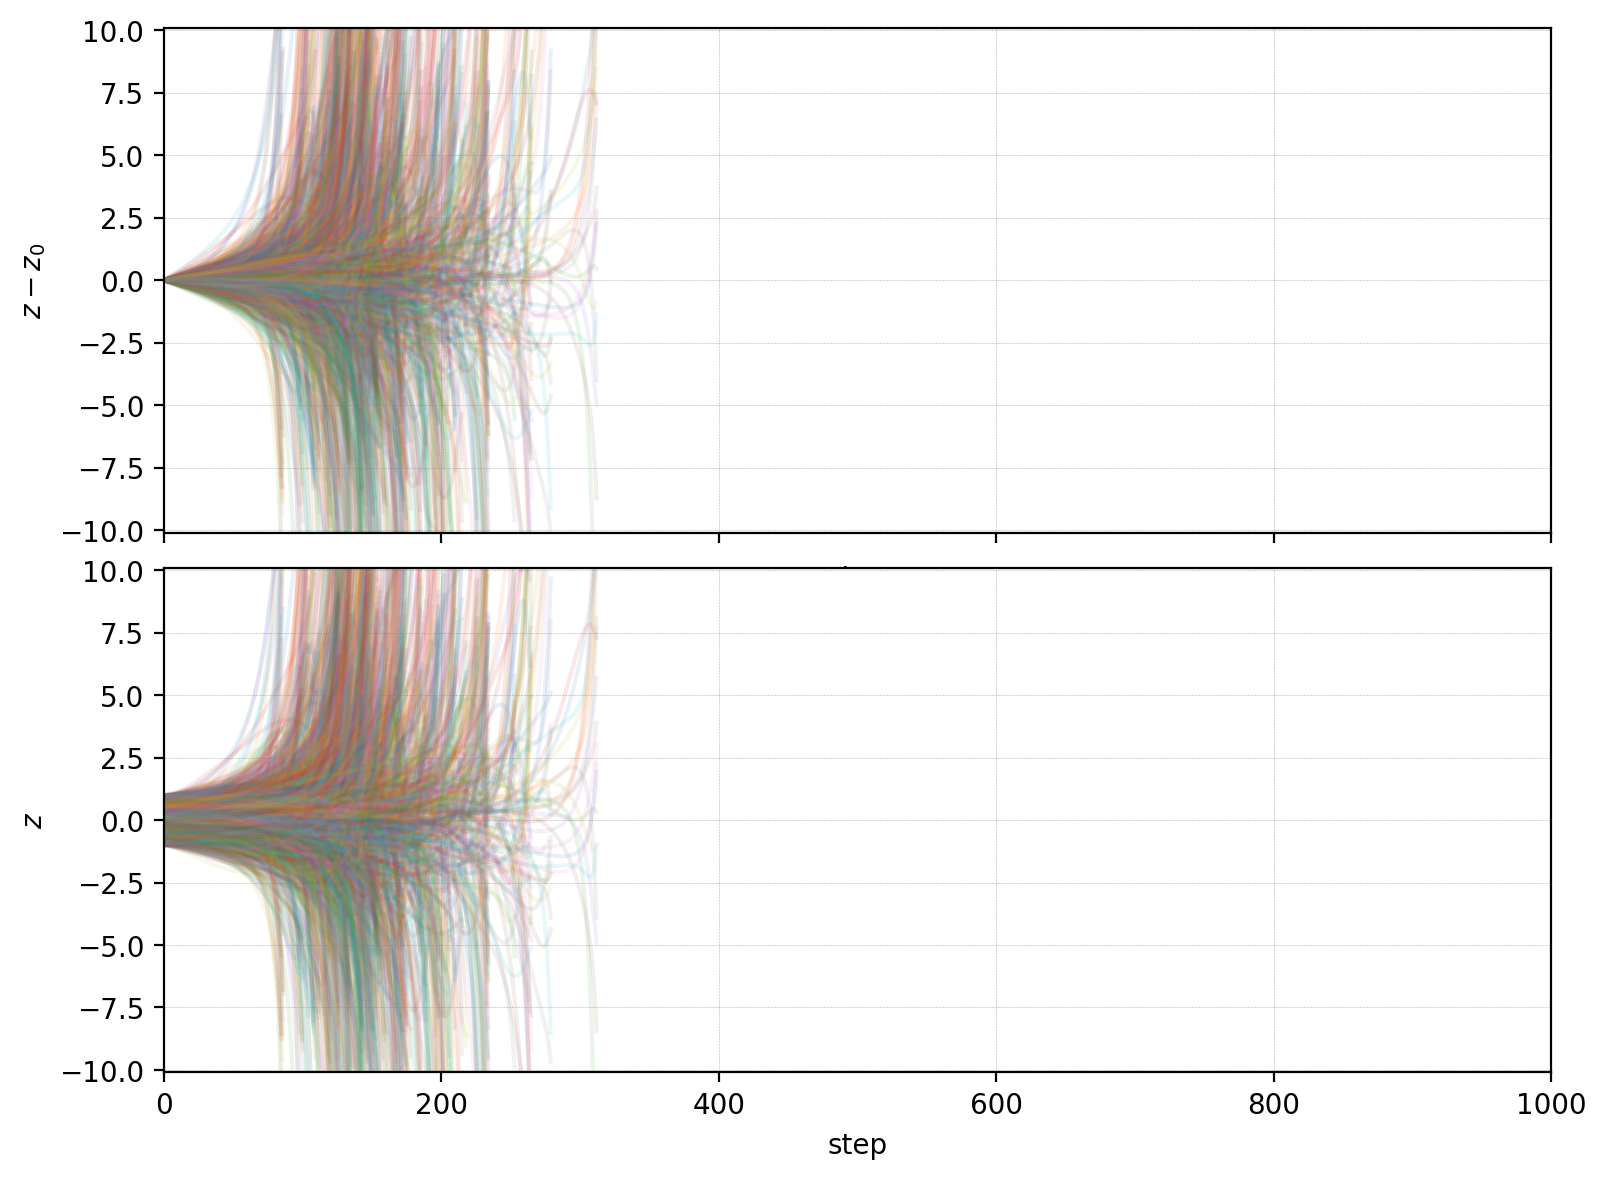

 >> Calculating standard deviations...


100%|██████████| 100/100 [00:00<00:00, 292.34it/s]


     >> Plotting...


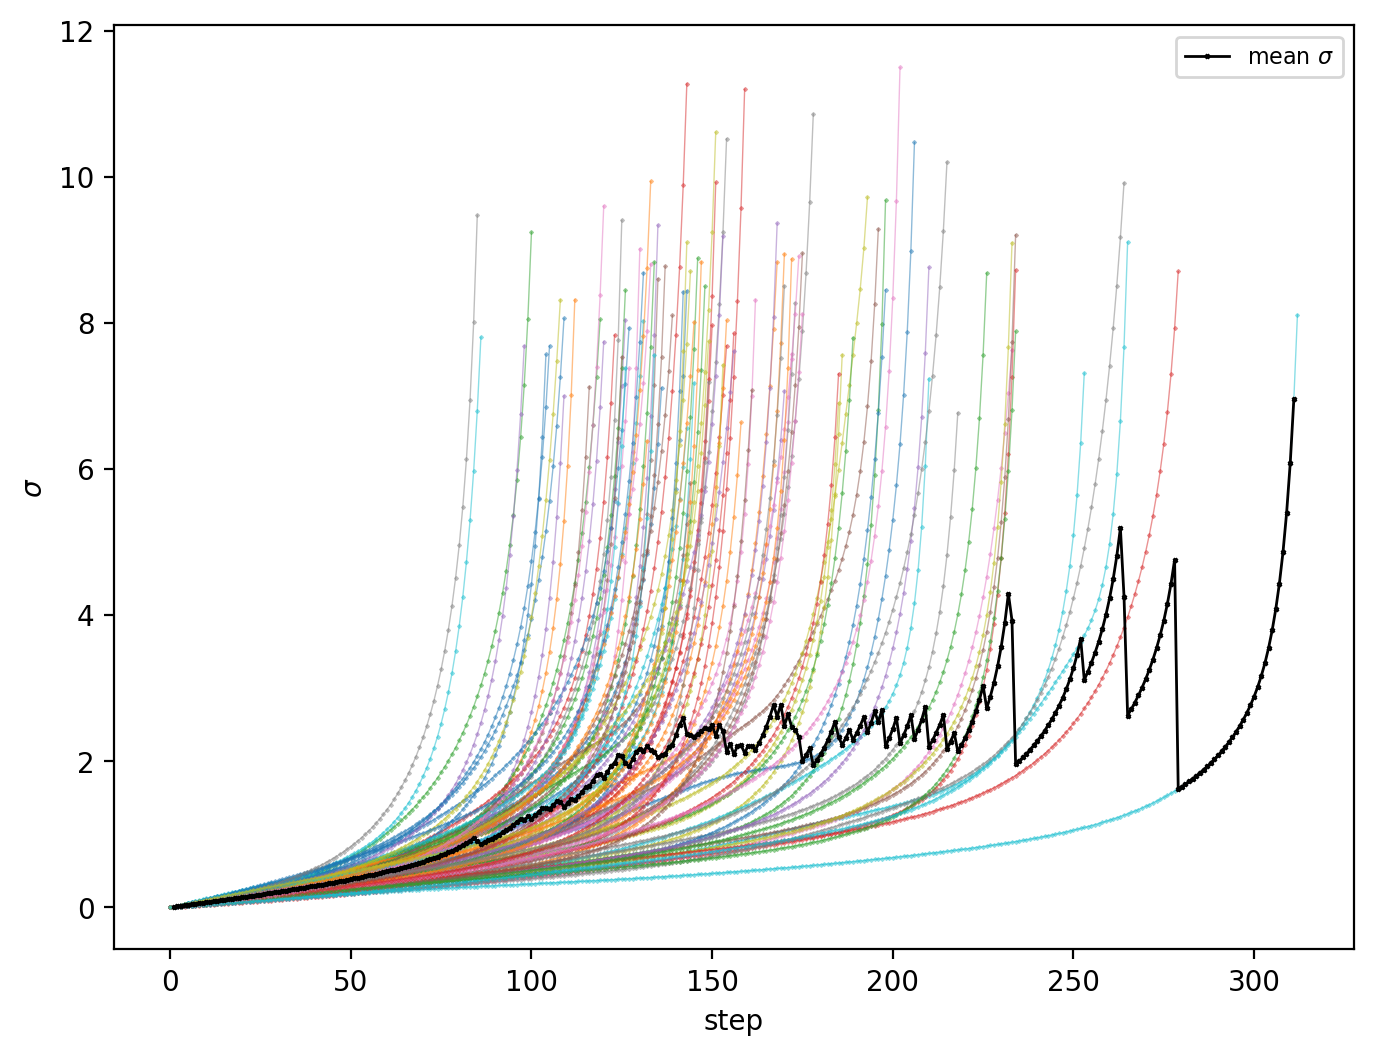

In [172]:
stds_20 = dynamics_test(20, 100, dt, atol, rtol, DEVICE, plot = True)

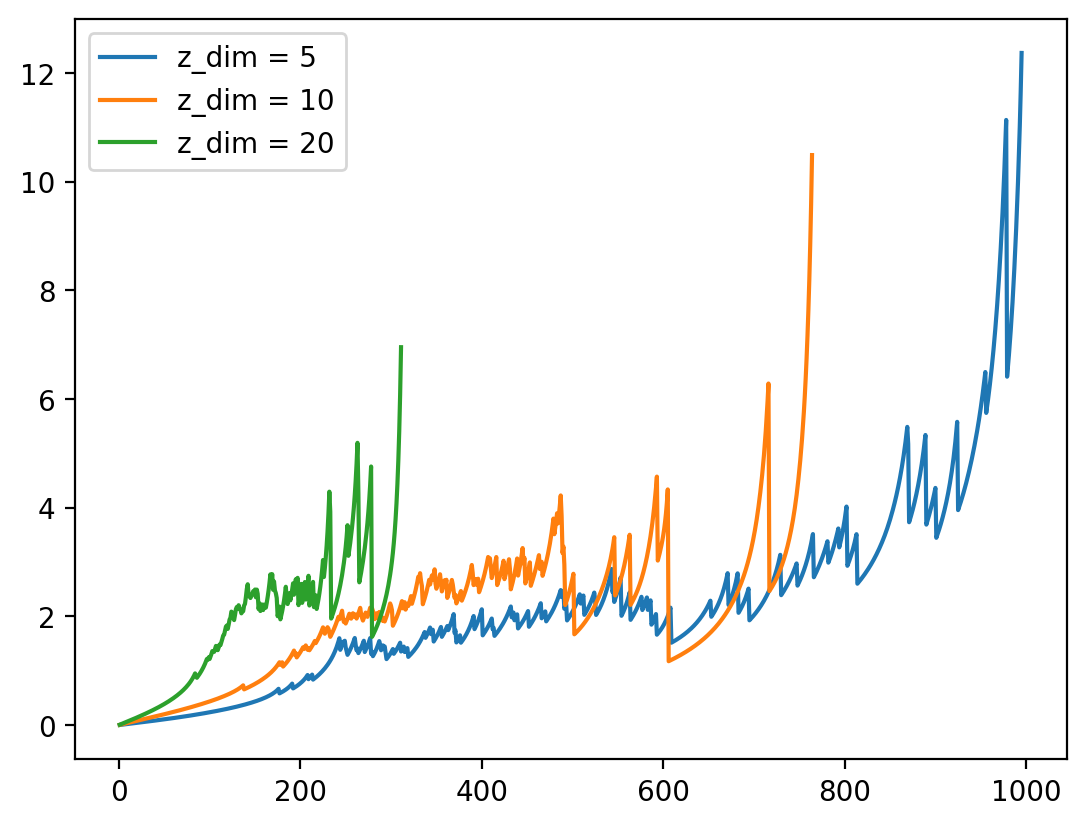

In [176]:
plt.plot(stds_5 , label = 'z_dim = 5')
plt.plot(stds_10, label = 'z_dim = 10')
plt.plot(stds_20, label = 'z_dim = 20')

plt.legend()
plt.show()

### with NNs

In [5]:
class LatentODE(torch.nn.Module):
    
    def __init__(self, n_latent):
        
        super().__init__()
        
        self.n_latent = n_latent

        self.lin_1 = torch.nn.Linear(n_latent, n_latent)
        self.lin_2 = torch.nn.Linear(n_latent, n_latent)
        self.lin_3 = torch.nn.Linear(n_latent, n_latent)
        
        self.relu = torch.nn.LeakyReLU(0.2)
        self.sigm = torch.nn.Sigmoid()
        
    def forward(self, t, z):
        
        result = self.relu(self.lin_1(z))
        result = self.relu(self.lin_2(result))
        result = self.sigm(self.lin_3(result))
        
        return result
    
g = LatentODE(n_latent)

elapsed time: 0.017088890075683594
success?      True


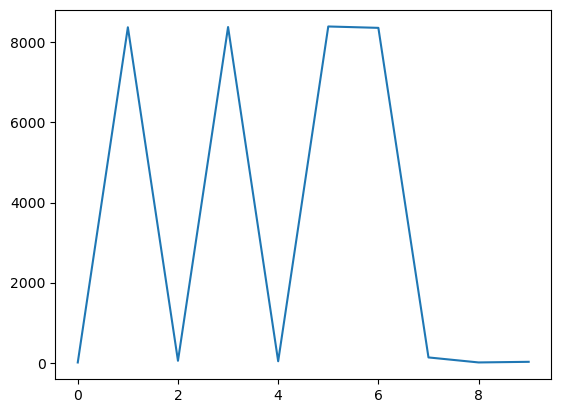

In [ ]:
# Setup solver
term                 = to.ODETerm(g.forward)#, with_args=True)
step_method          = to.Dopri5(term=term)
step_size_controller = to.IntegralController(atol=atol, rtol=rtol, term=term)
# step_size_controller = to.PIDController(atol=atol, rtol=rtol, pcoeff=0.2, icoeff=0.5, dcoeff=0.0, term=term)
solver               = to.AutoDiffAdjoint(step_method, step_size_controller)

# Compile solver\n",
jit_solver = torch.compile(solver)


# Setup initial value problem\n",
problem = to.InitialValueProblem(y0=z0_batch, t_eval=t_eval_batch)

# Run solver\n",
wct =- time()
solution = jit_solver.solve(problem, args=args)
# solution =     solver.solve(problem)#, args=args)
wct += time()
print("elapsed time:", wct)
print("success?     ", torch.all(solution.status == 0).item())

yt_torch = solution.ys[0][-1].detach().numpy()

plt.plot(yt_torch)